<a href="https://colab.research.google.com/github/ksanjeevan/fauxgrad/blob/master/fauxgrad_walkthrough.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<p style="text-align:left;">
<font size=6>
    <b>fauxgrad: simple autodiff in python</b>
</font>
    <span style="float:right;">
        <a href="https://github.com/ksanjeevan/fauxgrad"><b>See on GitHub!</b></a>
    </span>
</p>

----

To install `fauxgrad` and its dependencies, run:

In [ ]:
!pip install git+https://github.com/ksanjeevan/fauxgrad.git

## Table of Contents

* 1\. [Implementation: the `Value` class](#val)

    * 1.1\. [Addition](#add)
       
    * 1.2\. [Multiplication](#mul)
    
    * 1.3\. [Backward](#back)
    
    * 1.4\. [Other functions](#func)
    
    
* 2\. [Verification: Training a Neural Net from scratch](#demo)

In [1]:
from fauxgrad import Value
import inspect
from IPython import display

#helper display function 
def show_code(method, cls=Value):
    return display.Code(inspect.getsource(getattr(cls, method)), language='python')

<a name="val"/></a>
# 1. Implementing the `Value` class

Automatic differantiation is the technique which allows us to train deep neural networks. The idea is that whenever a function is applied to a value (*forward* pass), we should also keep track of its derivative (*backward* pass).

So if we take $a = f(x)$, then we also want to compute $grad = \partial f(x)/\partial x$. If we have a set of operations that define a [computational](https://colah.github.io/posts/2015-08-Backprop/) [graph](https://www.geeksforgeeks.org/computational-graphs-in-deep-learning/), we'll have to keep track of these derivative values at each node. This will allow use of the chain rule to cheaply evaluate the derivative of any variable with respect to another. An example:

```
a = 5
b = -3
c = a * b = 5 * -3
d = a + c = 5 + (-15)
e = d * 2 = -10 * 2
```

We might want to know $\partial e/ \partial a$. Well, we can use the chain rule to figure that out:

$$\partial e/ \partial a = \partial e/ \partial d * \partial d/ \partial a = \partial e/ \partial d * (\partial a/ \partial a + \partial c/ \partial a) = 2 * (1 + (-3)) = -4$$

We can implement this by: 

* A) **Wrapping our variables** with a class that handles/implements the derivatives of the functions we wish to use. See the `__init__` of our `Value` class below where we are using:
    
    1. `self.parents` to keep track of the `Value`s that resulted in this one being created (if we're talking about `d` from the example above, its parents would be `[a, c]`, while `a` has parents `[]`)

    2. `self.grad` to keep track of the cumulated derivative on this node

    3. `self.diff` to store the partial derivatives of the function that end up acting on this `Value` (more explanation of this later)
    
    The code used is:

In [2]:
show_code('__init__')

def __init__(self, val, parents=[]):
    self.val = float(val)
    self.parents = parents
    
    self.grad = 0
    self.diff = lambda grad: []


* B) **Implementing each function** we want to use and its derivative (i.e. the forward and backward pass). To keep the amount of code small, let's focus on the minimum number of operations that we'll need:

    - `__add__(x, y)`: adding two elements
    - `__mul__(x, y)`: multiplying two elements
    - `backward()`: calculating the gradient from this point backward through the computational graph
    - `activation & loss functions`: any activation functions that we might use, or that we might use in the loss function

<a name="add"/></a>
## 1.1. `__add__`

Our `Value` class stores the numeric data in the attribute `a.val`. So the forward pass when doing `c = a + b` will simply be `a.val + b.val` and storing it in a new `Value` (and making sure to set `c`'s parents to be `a` and `b`).

Let's see the code for implementing the addition function:

In [3]:
show_code('__add__')

def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    ret = Value(self.val + other.val, parents=[self, other])
    ret.diff = lambda grad: [grad, grad]
    return ret

<a name="mul"/></a>
## 1.2. `__mul__`

The forward pass for the multiplication function follows the same approach as in `__add__`, but let's look at the backward pass which we ignored before.

We want to take in the gradient that was propagated up to this node (formally: $\partial J/ \partial c$) and multiply it by our derivative value. Since we have two variables that formed `c`, our `diff` will return two values as well, corresponding to [$\partial c/ \partial a$ , $\partial c/ \partial b$]. 

That's why in the case of `__add__` above, both derivatives are `1` and we just propagate the value of the gradient, and in `__mul__` the derivatve $\partial c/ \partial a = b$ and $\partial c/ \partial b = a$. Let's look at the `__mul__` code:


In [4]:
show_code('__mul__')

def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    ret = Value(self.val * other.val, parents=[self, other])
    ret.diff = lambda grad: [grad * other.val, grad * self.val]
    return ret

In order for this to work fully, we'd also implement `__sub__`, `__pow__`, etc. but they all follow the same idea, and are fully done in [micrograd](https://github.com/karpathy/micrograd). Here we only implement the essential operations to later train a neural net (even though it will make some later code slightly ugly... it's a bit of a tradeoff).

This does mean that this happens:

```python
from fauxgrad import Value
Value(3) + (-2)
>>> Value(1.00; grad=0.00)
Value(3) - 2
>>> Traceback (most recent call last):
>>>   File "<stdin>", line 1, in <module>
>>> TypeError: unsupported operand type(s) for -: 'Value' and 'int'
```

Which is a bit annoying but again we're not going for completeness.

<a name="back"/></a>
## 1.3. `backward`

This function should now backtrack from the current node back through all the parent variables, calculating their respective partial derivatives along the way. We can split this up into:

* A) **Traversing the graph**. If `c` is the result of some function of `a`, we won't be able to get the gradient of `a` until we know the gradient of `c` (chain rule). So what we need is a *reverse* [topologcal ordering](https://www.geeksforgeeks.org/topological-sorting/) of the nodes in the computational graph (e.g. in the example from above we would want the ordering `[e, d, c, b, a]`).

    This can be seen in the helper function:

In [5]:
show_code('_rev_topo_sort')

def _rev_topo_sort(self):
    def traverse(node):
      if node in visit: return
      visit.add(node)
      for p in node.parents: traverse(p)
      ret.append(node)

    visit = set(); ret = []
    traverse(self)
    return reversed(ret)

We now can take each node, and use its `diff` function to propagate the gradient to their parents. This can be seen in the `backward` function: 

In [6]:
show_code('backward')

def backward(self):
    self.grad = 1.0 # implicit gradient creation
    for node in self._rev_topo_sort():
      gradients = node.diff(node.grad)
      for p, g in zip(node.parents, gradients): p.grad += g

We start with a `gradient=1` (since we've done the ordering correctly in `_rev_topo_sort`, `self == nodes[0]`), and for each node we update their parents' cumulated gradient. 

The mathematical pseudocode of what is being computed at each iteration in the outter loop is:

```
for ...:

    dc/da, dc/db = c.diff(c.grad)

    a.grad += dc/da
    b.grad += dc/db
```

where of course a node can have two parents, no parents, one parent, etc. 

<a name="func"/></a>
## 1.4. Other Functions

We implement three more functions for our `Value` class in order to be able to run the demo in section [2.](#demo). First we can see the `relu`:

In [7]:
show_code('relu')

def relu(self):
    ret = Value(max(0, self.val), parents=[self])
    ret.diff = lambda grad: [grad * (self.val > 0)]
    return ret

Unlike `__add__` and `__mul__`, `relu` only has one parent (the `Value` the `relu` was applied to). As we're going to solve a binary classification problem, we'll also use a `sigmoid` activation for the final layer:

In [8]:
show_code('sigmoid')

def sigmoid(self):
    _sigmoid = lambda x: 1/(1 + math.exp(-x))
    ret = Value(_sigmoid(self.val), parents=[self])
    ret.diff = lambda grad: [grad * (1-_sigmoid(self.val))*_sigmoid(self.val)]
    return ret

And we'll make of $\sigma(x)'=\sigma(x) * (1 - \sigma(x))$. Finally for the implementation of our [cross entropy](https://en.wikipedia.org/wiki/Cross_entropy) loss function, we'll also need the `log`:

In [9]:
show_code('log')

def log(self):
    ret = Value(math.log(self.val), parents=[self])
    ret.diff = lambda grad: [grad * (1/self.val)]
    return ret

Implementing all these function follows the same procedure, and extending this to `__pow__`, `__sub__` would follow the same. 

With a bit of helper code, we now can move on to using this minimal engine to train a neural network! 

<a name="demo"/></a>
# Using `fauxgrad` to train a Neural Net for binary classification 

In [10]:
import matplotlib.pyplot as plt
import numpy as np

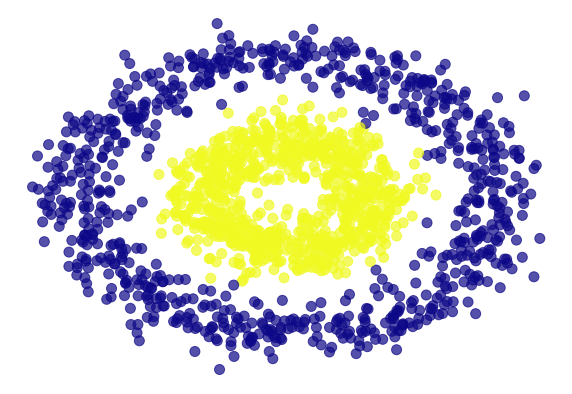

In [11]:
# collect 2d toy data of a donut in a donut
from fauxgrad.utils import generate_circles, visualize_plot
X, Y = generate_circles(num_samples=1600)

# Let's display the data
plt.figure(figsize=(10,7))
plt.scatter(X[:,0], X[:,1], c=np.squeeze(Y), cmap='plasma', s=100, alpha=0.7)
ax = plt.gca()
ax.set_facecolor((0.95, 0.95, 0.95)); plt.axis('off'); plt.show()

In [12]:
# Value is the engine of the automatic differentiation, while
# Linear simply implements `List[Value]` based matrix multiplication
# the gradients will be computed automatically!
from fauxgrad import Value, Linear, cross_entropy

class MyNet:
    
    def __init__(self, hidden_size=12):
        self.l1 = Linear(2, hidden_size, 'relu')
        self.l2 = Linear(hidden_size, 1, 'sigmoid')
        
    def __call__(self, x):
        x = self.l1(x)
        x = self.l2(x)
        return x

    def parameters(self):
        return self.l1.parameters() + self.l2.parameters()


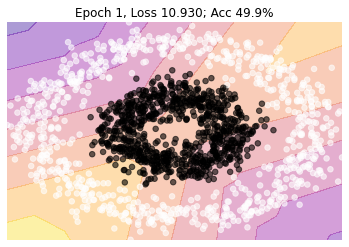

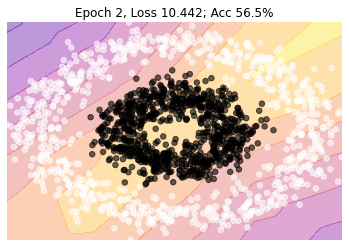

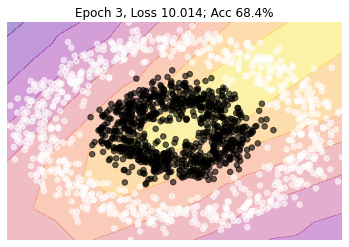

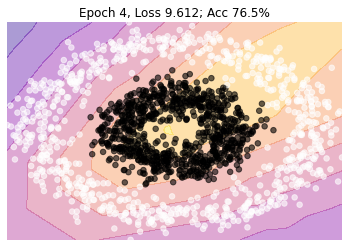

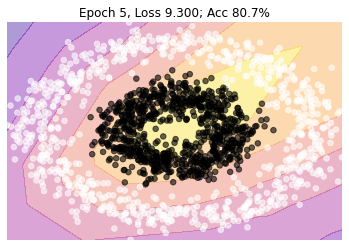

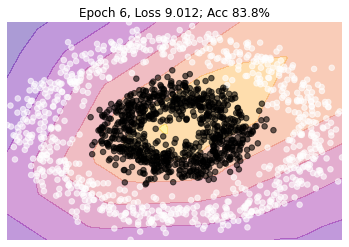

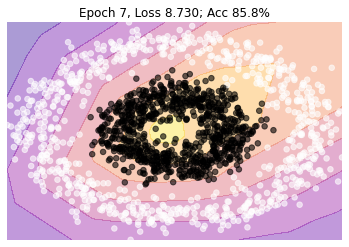

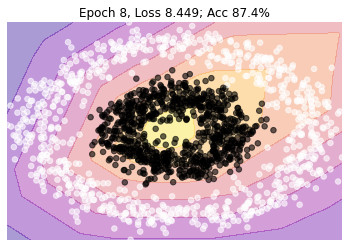

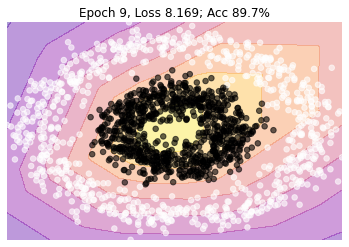

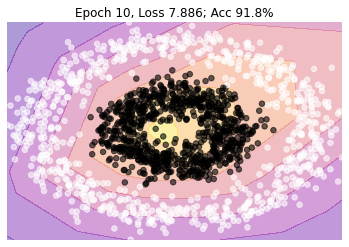

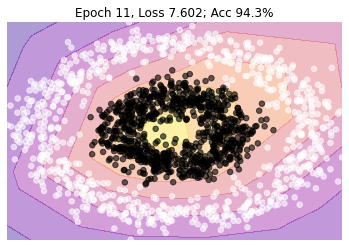

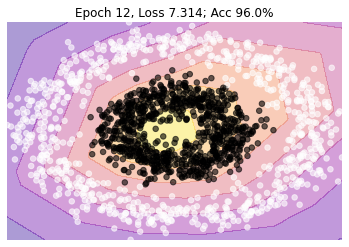

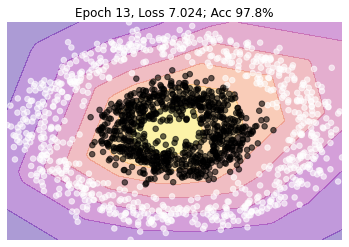

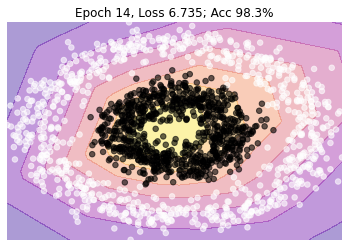

In [14]:
# SGD will simply loop over the flattened parameters that were passed to it,
# and for each one compute `p.val -= lr * p.grad`
from fauxgrad.optim import SGD

m = MyNet()

data = X.reshape(100, 16, 2) 
labels = Y.reshape(100, 16)

epochs = 14
lr = 0.001
opt = SGD(m.parameters(), lr=lr)

for epoch in range(1, epochs+1):
    losses = []; accs = []
    
    for i in range(data.shape[0]):
        x = [[Value(d[0]), Value(d[1])] for d in data[i]]

        opt.zero_grad()
        yhat = [m(datum)[0] for datum in x]

        loss = cross_entropy(yhat, labels[i])
        loss.backward()
        
        losses.append(loss.val)
        accs.extend([int(y.val>0.5)==l for y, l in zip(yhat, labels[i])])

        opt.step()
    title = 'Epoch %d, Loss %.3f; Acc %.1f%%'%(epoch,
                                               sum(losses)/len(losses), 
                                               100*sum(accs)/len(accs))
    visualize_plot(X, Y, m, title=title)